# Bilby Test Run

Estimating GP linear coefficients with MCMC

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import bilby
from bilby.core.utils import random
import json

In [2]:
# set up
random.seed(123)
label = "test"
outdir = "outdir"
bilby.utils.check_directory_exists_and_if_not_mkdir(outdir)

In [3]:
sample_dat_path = "../synthetic_data/N11000_AP10_noise0.5_seed1/Size500/Rep3.csv"
sample_dat = pd.read_csv(sample_dat_path)

val_dat_path = "../synthetic_data/N11000_AP10_noise0.5_seed1/N11000_AP10_noise0.5_seed1_meta.json"
with open(val_dat_path, 'r') as f:
    val_dat = json.load(f)

from sklearn.model_selection import train_test_split

X = sample_dat.iloc[:, :-1].values  #all columns except the last
y = sample_dat.iloc[:, -1].values   #last column

Xtrain, Xtest, ytrain, ytest = train_test_split(X, y, test_size=0.2, random_state=22)

In [50]:
# custom likelihood for multi-dimensional linear regression
class LinearRegressionLikelihood(bilby.Likelihood):
    def __init__(self, X, y, sigma):
        # store data
        self.X = np.asarray(X)
        self.y = np.asarray(y)
        self.sigma = sigma

        # define parameters
        parameters = {f"beta{i}": None for i in range(self.X.shape[1])}
        super().__init__(parameters=parameters)

    def log_likelihood(self):
        betas = np.array([self.parameters[f"beta{i}"] for i in range(self.X.shape[1])])
        y_model = self.X @ betas
        residual = self.y - y_model
        return np.sum(-0.5 * (residual / self.sigma) ** 2 - 0.5 * np.log(2 * np.pi * self.sigma ** 2)) # log likelihood for Gaussian noise

In [7]:
# model function

def model_function(X, **params): 
    betas = np.array([params[f"beta{i}"] for i in range(X.shape[1])]) # make beta for each column
    return X @ betas 

# make priors
priors = dict()
for i in range(30):
    priors[f"beta{i}"] = bilby.core.prior.Uniform(-5, 5, f"beta{i}") # define uniform priors for each beta coefficient

# define the likelihood based on the Gaussian noise model
likelihood = LinearRegressionLikelihood(
    X = Xtrain,
    y = ytrain,
    sigma = 0.5)

#define injection parameters for validation (true coefficient values)
injection_parameters = {
   f"beta{i}": val_dat['beta'][i] for i in range(len(val_dat['beta']))}

# run MCMC sampler
result = bilby.run_sampler(
    likelihood=likelihood, # likelihood function
    priors=priors, # prior distributions
    sampler="dynesty", 
    nlive=250,
    injection_parameters=injection_parameters, # used for validation
    outdir=outdir,
    label=label
    #plot=True
)

13:55 bilby INFO    : Running for label 'test', output will be saved to 'outdir'
13:55 bilby INFO    : Analysis priors:
13:55 bilby INFO    : beta0=Uniform(minimum=-5, maximum=5, name='beta0', latex_label='beta0', unit=None, boundary=None)
13:55 bilby INFO    : beta1=Uniform(minimum=-5, maximum=5, name='beta1', latex_label='beta1', unit=None, boundary=None)
13:55 bilby INFO    : beta2=Uniform(minimum=-5, maximum=5, name='beta2', latex_label='beta2', unit=None, boundary=None)
13:55 bilby INFO    : beta3=Uniform(minimum=-5, maximum=5, name='beta3', latex_label='beta3', unit=None, boundary=None)
13:55 bilby INFO    : beta4=Uniform(minimum=-5, maximum=5, name='beta4', latex_label='beta4', unit=None, boundary=None)
13:55 bilby INFO    : beta5=Uniform(minimum=-5, maximum=5, name='beta5', latex_label='beta5', unit=None, boundary=None)
13:55 bilby INFO    : beta6=Uniform(minimum=-5, maximum=5, name='beta6', latex_label='beta6', unit=None, boundary=None)
13:55 bilby INFO    : beta7=Uniform(mini

21676it [10:24, 29.53it/s, bound:9215 nc:490 ncall:7.4e+06 eff:0.3% logz=-942.05+/-0.59 dlogz:17.1>0.1]    

14:05 bilby INFO    : Written checkpoint file outdir/test_resume.pickle
/Users/liviafingerson/Documents/GitHub/IBM/IEMS399-GP/.venv/lib/python3.13/site-packages/dynesty/plotting.py:318: UserWarning: Attempting to set identical low and high ylims makes transformation singular; automatically expanding.
  axes[i].set_ylim([ymin, ymax])


28147it [14:07, 31.96it/s, bound:12486 nc:414 ncall:1.0e+07 eff:0.3% logz=-923.82+/-0.64 dlogz:0.108>0.1]

14:09 bilby INFO    : Written checkpoint file outdir/test_resume.pickle


28167it [14:20, 31.96it/s, bound:12496 nc:  1 ncall:1.0e+07 eff:0.3% logz=-923.80+/-0.64 dlogz:0.000408>0.1]

/Users/liviafingerson/Documents/GitHub/IBM/IEMS399-GP/.venv/lib/python3.13/site-packages/dynesty/plotting.py:318: UserWarning: Attempting to set identical low and high ylims makes transformation singular; automatically expanding.
  axes[i].set_ylim([ymin, ymax])


28167it [14:21, 32.70it/s, bound:12496 nc:  1 ncall:1.0e+07 eff:0.3% logz=-923.80+/-0.64 dlogz:0.000408>0.1]

14:09 bilby INFO    : Rejection sampling nested samples to obtain 2300 posterior samples
14:09 bilby INFO    : Sampling time: 0:14:21.293616


14:09 bilby INFO    : Summary of results:
nsamples: 2300
ln_noise_evidence:    nan
ln_evidence: -923.799 +/-  0.719
ln_bayes_factor:    nan +/-  0.719



In [47]:
# open test result file
with open(f"{outdir}/test_result.json", 'r') as f:
    test_result = json.load(f)

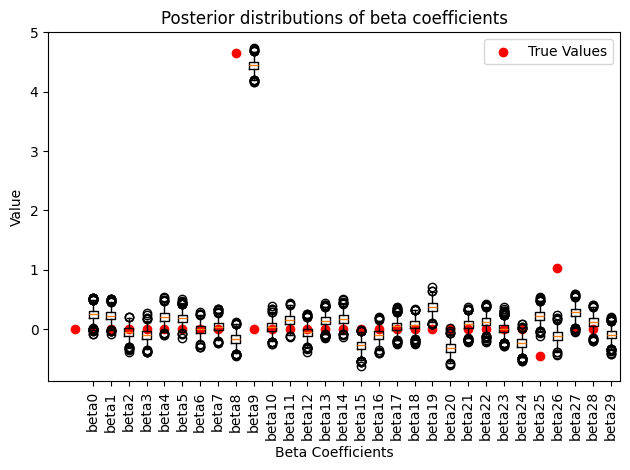

In [48]:
plt.boxplot([test_result['posterior']['content'][f'beta{i}'] for i in range(30)], 
            tick_labels=[f'beta{i}' for i in range(30)])
# add true values (injection parameters) as red dots
true_betas = [injection_parameters[f'beta{i}'] for i in range(30)]
plt.scatter([f'beta{i}' for i in range(30)], true_betas, color='red', label='True Values')
plt.xlabel('Beta Coefficients') 
plt.xticks(rotation=90)
plt.title('Posterior distributions of beta coefficients')
plt.ylabel('Value')
plt.tight_layout()
plt.legend()
plt.show()

In [49]:
# print posterior means for beta coefficients
for i in range(30):
    print(f"beta{i}: {np.array(test_result['posterior']['content'][f'beta{i}']).mean()}")


# print credible intervals for beta coefficients
for i in range(30):
    lower = np.percentile(test_result['posterior']['content'][f'beta{i}'], 2.5)
    upper = np.percentile(test_result['posterior']['content'][f'beta{i}'], 97.5)
    print(f"beta{i} 95% CI: [{lower}, {upper}]")

beta0: 0.25116467169998025
beta1: 0.22765209562255978
beta2: -0.05177463786634877
beta3: -0.09846366506092905
beta4: 0.20065929940051727
beta5: 0.18565350946573514
beta6: -0.005932849762674988
beta7: 0.04369682638033782
beta8: -0.1691537911372738
beta9: 4.441795431781442
beta10: 0.036682638354022204
beta11: 0.149841685383388
beta12: -0.05439109214115156
beta13: 0.14442830088560393
beta14: 0.17414109330971078
beta15: -0.27721296574034715
beta16: -0.09987231346068731
beta17: 0.05183853956001567
beta18: 0.07397362920331017
beta19: 0.37010675632790435
beta20: -0.31961834243195203
beta21: 0.07752347929313685
beta22: 0.1274529218394118
beta23: 0.006251717852154821
beta24: -0.23121232311778434
beta25: 0.22494889389475642
beta26: -0.11463178698877359
beta27: 0.281983858709005
beta28: 0.11861232918273312
beta29: -0.09817082933286285
beta0 95% CI: [0.06891242663737876, 0.434294926897959]
beta1 95% CI: [0.05304543275946805, 0.40435422209165384]
beta2 95% CI: [-0.22932923497943636, 0.1259212156012